In [1]:
from src.models.lbcnn.lbcnn_parts import ConvLBP
from src.models.dsc.dsc_lbc_unet import DSCConvLBP
import torch.nn as nn
import torch
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP, SkinnySmallUNetLBP
from src.datasets.ice import Ice
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [3]:
layer1 = nn.Conv2d(3, 3, kernel_size=3)
layer2 = ConvLBP(3, 3)

In [4]:
print(layer1.weight.data.numpy().shape)
print(layer2.weight.data.numpy().shape)

(3, 3, 3, 3)
(3, 3, 3, 3)


In [5]:
weights1 = layer1.weight.data.numpy()
weights2 = layer2.weight.data.numpy()

In [6]:
weights1[0]

array([[[ 0.02601616,  0.11693056,  0.16377093],
        [-0.17390822,  0.0259165 ,  0.16464901],
        [ 0.17147093,  0.09469462,  0.15063304]],

       [[ 0.02434446, -0.15260205,  0.12075678],
        [-0.07501121,  0.05568367, -0.03578801],
        [-0.1895049 , -0.09714251,  0.0195065 ]],

       [[ 0.14242333, -0.0712828 ,  0.14337683],
        [-0.03083569, -0.14482556, -0.1340347 ],
        [-0.00603031, -0.18593928,  0.0879828 ]]], dtype=float32)

In [7]:
weights2[0]

array([[[ 1.,  1., -1.],
        [ 0., -1.,  0.],
        [-1.,  0.,  0.]],

       [[ 0.,  0.,  1.],
        [ 1.,  0., -1.],
        [ 1.,  1.,  0.]],

       [[ 0., -1., -1.],
        [ 0.,  1.,  0.],
        [ 0., -1., -1.]]], dtype=float32)

In [8]:
weights = next(layer1.parameters())

In [9]:
matrix_proba = torch.FloatTensor(weights.data.shape).fill_(0.5)

In [40]:
torch.bernoulli(matrix_proba).unique()

tensor([0., 1.])

In [10]:
binary_weights = torch.bernoulli(matrix_proba) * 2 - 1

In [45]:
(torch.rand(matrix_proba.shape) > 0).unique()

tensor([True])

In [11]:
torch.rand(matrix_proba.shape) > 0

tensor([[[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]]]])

In [12]:
nn.Conv2d(3, 64, kernel_size=1).weight.data.numpy().shape

(64, 3, 1, 1)

In [4]:
device = 'cpu'
checkpoint = 'skinny_small_lbc_unet_sparcity_12'
epoch = 19
checkpoint_path = f'/home/dsola/repos/PGA-Net/checkpoints/{checkpoint}/epoch{epoch + 1}.pth'
net = SkinnySmallUNetLBP(3, 3)
net.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [5]:
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_scale = 0.35
img_crop = 256

test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

test_loader = DataLoader(test_set, batch_size=batch_size)

out = nn.Softmax(dim=1)

In [6]:
for batch in test_loader:
    pass

In [7]:
img = batch['image'].to(device=device)

In [8]:
img.shape

torch.Size([1, 3, 256, 256])

In [9]:
output = net(img)
sftmx = out(output)
argmx = torch.argmax(sftmx, dim=1)

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


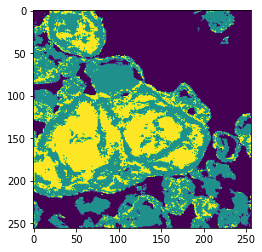

In [10]:
argmx_np = argmx.squeeze(0).detach().numpy()
plt.imshow(argmx_np)

In [11]:
img.shape

torch.Size([1, 3, 256, 256])

In [12]:
blah = net(img)

In [13]:
x1 = net.inc.batch_norm(img)
x2 = net.inc.conv_lbp(x1)
x3 = net.inc.conv_1x1(x2)
x4 = net.down1.maxpool_conv[0](x3)
x5 = net.down1.maxpool_conv[1].batch_norm(x4)
x6 = net.down1.maxpool_conv[1].conv_lbp(x5)
x7 = net.down1.maxpool_conv[1].conv_1x1(x6)

In [14]:
x1.shape

torch.Size([1, 3, 256, 256])

In [15]:
x7[0,0,:,:]

tensor([[ -5.9215, -12.5836, -10.5367,  ..., -18.8676, -15.3084,  -8.3931],
        [ -6.4128, -12.8988, -12.5151,  ..., -23.3340, -18.2241,  -8.9958],
        [ -5.9569, -13.1044, -16.6157,  ..., -27.6611, -24.1920, -11.6889],
        ...,
        [ -1.4335,  -6.0834,  -0.0684,  ..., -10.2907, -11.4380,  -7.6093],
        [ -6.9941,  -3.0037,   0.5665,  ...,  -8.7226,  -7.8221,  -5.4845],
        [-13.6924,   5.8316,  -0.7514,  ...,  -4.5240,  -3.6140,  -7.2125]],
       grad_fn=<SliceBackward>)

In [16]:
net

SkinnySmallUNetLBP(
  (inc): BlockLBPUNet(
    (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_lbp): ConvLBP(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): DownLBP(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): BlockLBPUNet(
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_lbp): ConvLBP(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_1x1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
  (down2): DownLBP(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): BlockLBPUNet(
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [17]:
net.inc.batch_norm.register_forward_hook(get_activation('inc_batch_norm'))
net.inc.conv_lbp.register_forward_hook(get_activation('inc_conv_lbp'))
net.inc.conv_1x1.register_forward_hook(get_activation('inc_conv_1x1'))
net.down1.maxpool_conv[0].register_forward_hook(get_activation('down1_mp'))
net.down1.maxpool_conv[1].batch_norm.register_forward_hook(get_activation('down1_batch_norm'))
net.down1.maxpool_conv[1].conv_lbp.register_forward_hook(get_activation('down1_conv_lbp'))
net.down1.maxpool_conv[1].conv_1x1.register_forward_hook(get_activation('down1_conv_1x1'))

output = net(img)

In [18]:
activation['inc_conv_lbp']

tensor([[[[ 1.5727, -0.0611, -0.1803,  ..., -0.5996, -0.6335, -0.4469],
          [-1.5035, -3.7041, -3.7052,  ..., -3.5963, -3.3303, -1.6351],
          [-0.7537, -2.4744, -1.9100,  ..., -4.4014, -4.9703, -3.1391],
          ...,
          [-1.8752, -4.1809, -2.2205,  ..., -2.4295, -2.6457, -0.6828],
          [-3.1794, -3.3087, -1.4855,  ..., -2.7697, -3.0777, -1.2373],
          [ 3.6576,  4.4104,  1.5198,  ..., -3.1473, -3.1095, -1.2057]],

         [[-1.3299, -0.5297, -0.4435,  ..., -0.6492, -0.2117,  0.7862],
          [-2.7638, -2.3130, -2.8246,  ..., -2.8886, -2.7092, -2.1102],
          [-2.4486, -1.8309, -2.4150,  ..., -2.6928, -2.5145, -3.3497],
          ...,
          [-1.5745, -2.6718, -3.5963,  ..., -1.5414, -2.2433, -1.8205],
          [-0.6443, -1.3654, -4.2201,  ..., -2.2617, -2.2320, -2.2775],
          [ 0.3603,  2.4019,  1.1965,  ..., -2.5252, -2.3006, -2.8062]],

         [[ 3.0802,  1.5562,  1.1038,  ...,  1.7364,  1.5791,  0.5030],
          [ 2.3965, -0.5456, -

In [19]:
net.inc.conv_lbp.weight

Parameter containing:
tensor([[[[-1.,  1.,  1.],
          [ 1.,  1., -1.],
          [ 1., -1.,  1.]],

         [[ 1.,  1.,  1.],
          [ 1.,  1.,  1.],
          [-1., -1., -1.]],

         [[ 1., -1.,  1.],
          [-1., -1.,  1.],
          [ 1., -1., -1.]]],


        [[[ 1.,  1., -1.],
          [ 1.,  1., -1.],
          [-1., -1.,  1.]],

         [[ 1.,  1., -1.],
          [-1., -1.,  1.],
          [-1., -1.,  1.]],

         [[-1.,  1.,  1.],
          [-1.,  1.,  1.],
          [ 1.,  1., -1.]]],


        [[[-1., -1., -1.],
          [ 1., -1.,  1.],
          [ 1., -1., -1.]],

         [[ 1.,  1.,  1.],
          [ 1.,  1.,  1.],
          [-1., -1., -1.]],

         [[ 1., -1.,  1.],
          [ 1.,  1., -1.],
          [-1., -1., -1.]]]])

In [30]:
activation['inc_conv_1x1']

tensor([[[[ 0.6046,  0.6046,  0.6046,  ...,  0.6051,  0.6050,  0.6047],
          [ 0.6047,  0.6047,  0.6046,  ...,  0.6050,  0.6050,  0.6051],
          [ 0.6043,  0.6041,  0.6037,  ...,  0.6052,  0.6053,  0.6053],
          ...,
          [ 0.6039,  0.6038,  0.6042,  ...,  0.6045,  0.6045,  0.6046],
          [ 0.6035,  0.6022,  0.6028,  ...,  0.6045,  0.6044,  0.6045],
          [ 0.6017,  0.6011,  0.6018,  ...,  0.6043,  0.6042,  0.6041]],

         [[-0.2223, -0.2223, -0.2223,  ..., -0.2222, -0.2222, -0.2221],
          [-0.2223, -0.2223, -0.2223,  ..., -0.2221, -0.2221, -0.2220],
          [-0.2223, -0.2223, -0.2223,  ..., -0.2221, -0.2221, -0.2220],
          ...,
          [-0.2223, -0.2223, -0.2223,  ..., -0.2223, -0.2223, -0.2223],
          [-0.2224, -0.2224, -0.2224,  ..., -0.2223, -0.2223, -0.2223],
          [-0.2224, -0.2224, -0.2224,  ..., -0.2223, -0.2223, -0.2222]],

         [[ 0.3911,  0.3911,  0.3911,  ...,  0.3917,  0.3916,  0.3918],
          [ 0.3911,  0.3911,  